In [2]:
import rosbag
from cv_bridge import CvBridge
import numpy as np
import onnxruntime
import cv2
import matplotlib.pyplot as plt

In [3]:
def read_images(bag):
    #Read from bag
    bag = rosbag.Bag(bag)
    # Read Image and CompressedImage
    bridge = CvBridge()
    count = 0
    imgs = []
    for topic, msg, t in bag.read_messages():
        if msg._type == "sensor_msgs/Image":
            img = bridge.imgmsg_to_cv2(msg, desired_encoding='passthrough')
            imgs.append(img)
            count += 1
        elif msg._type == "sensor_msgs/CompressedImage":
            img = bridge.compressed_imgmsg_to_cv2(msg, desired_encoding='passthrough')
            imgs.append(img)
            count += 1
    print("Read %d images from bag" % count)
    return imgs

def compute_netvlad(sess, imgs):
    # Compute NetVLAD with Onnx
    netvlads = []
    for img in imgs:
        if len(img.shape) > 2 and img.shape[2] == 3:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img_gray = img
        img_gray = img_gray.astype(np.float32)[np.newaxis,:,:,np.newaxis]
        output = sess.run(None, {sess.get_inputs()[0].name: img_gray})
        netvlads.append(output[0].flatten())
    netvlads = np.array(netvlads)
    print("netvlads shape: ", netvlads.shape)
    return netvlads


In [4]:
bag_path = "/home/xuhao/data/d2slam/drone3-RI/drone1.bag"
images = read_images(bag_path)


Read 47603 images from bag


In [5]:
netvlad_model = "/home/xuhao/d2slam_ws/src/D2SLAM/models/mobilenetvlad_dyn_batch_size.onnx"
sess = onnxruntime.InferenceSession(netvlad_model, providers=["CUDAExecutionProvider"])
netvlads = compute_netvlad(sess, images)

netvlads shape:  (47603, 4096)


In [6]:
# PCA with sklearn of netvlads
# Decompose netvlads to 1024 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=1024)
pca.fit(netvlads)
netvlads_pca = pca.transform(netvlads)
print("netvlads_pca shape: ", netvlads_pca.shape)
# Normalize netvlads_pca
netvlads_pca = netvlads_pca / np.linalg.norm(netvlads_pca, axis=1, keepdims=True)


netvlads_pca shape:  (47603, 1024)


dot_product err variance:  0.012703997
dot_product = 0.647379 * dot_product_pca + 0.341641
dot_product_pca = 1.461383 * dot_product + -0.499261


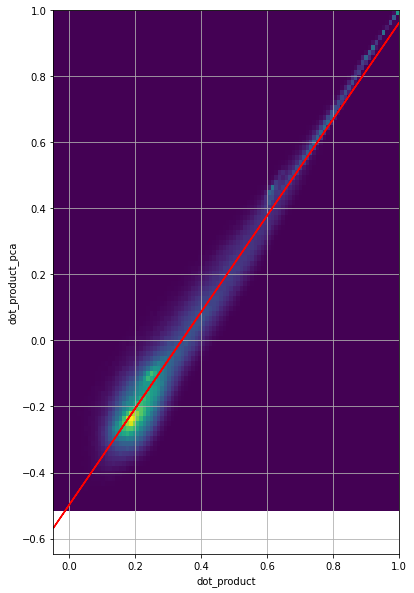

dot_product dot_product_pca
0.5 0.23143065880125185
0.6 0.3775689572494522
0.7 0.5237072556976525
0.8 0.669845554145853
0.9 0.8159838525940535


In [9]:

# Verify the PCA result, we random choose two netvlad vector 1000 times
# and compute the dot product before and after PCA by compute the variance
import random
dot_product = []
dot_product_pca = []
for i in range(1000000):
    idx1 = random.randint(0, len(netvlads)-1)
    idx2 = random.randint(0, len(netvlads)-1)
    dot_product.append(np.dot(netvlads[idx1,:], netvlads[idx2,:]))
    dot_product_pca.append(np.dot(netvlads_pca[idx1,:], netvlads_pca[idx2,:]))
dot_product = np.array(dot_product)
dot_product_pca = np.array(dot_product_pca)
print("dot_product err variance: ", np.var(dot_product-dot_product_pca))
plt.figure(figsize=(10,10))
heatmap, xedges, yedges = np.histogram2d(dot_product, dot_product_pca, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.xlabel('dot_product')
plt.ylabel('dot_product_pca')
plt.grid(which='both')
# Set to equal scale
# Fit line of dot_product_pca to dot_product
m, b = np.polyfit(dot_product_pca, dot_product, 1)
print("dot_product = %f * dot_product_pca + %f" % (m, b))
m, b = np.polyfit(dot_product, dot_product_pca, 1)
print("dot_product_pca = %f * dot_product + %f" % (m, b))
plt.plot(dot_product, m*dot_product + b, 'r')
plt.show()
#Print a table of original and PCA dot product
print("dot_product dot_product_pca")
for i in range(5, 10):
    thres = i / 10
    print(thres, m*thres+b)

In [ ]:
pca_result = pca.components_.copy()
#Add the mean vector
pca_result = np.vstack((pca.mean_, pca_result))
print("pca_result shape: ", pca_result.shape)
# Save the pca result as csv
np.savetxt("../models/netvlad_pca.csv", pca_result, delimiter=",")

pca_result shape:  (1025, 4096)


In [ ]:
# Load the pca result
pca_comp_sp = np.loadtxt("../models/components_.csv", delimiter=",")
pca_mean_sp = np.loadtxt("../models/mean_.csv", delimiter=",")
# Save as stack 
pca_result_sp = np.vstack((pca_mean_sp, pca_comp_sp))
print("pca_result_sp shape: ", pca_result_sp.shape)
np.savetxt("../models/superpoint_pca.csv", pca_result_sp, delimiter=",")

pca_result_sp shape:  (65, 256)


In [ ]:
1.46 * 0.8 - 